In [1]:
import numpy as np
import json
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl

## 2D

In [2]:
def str2mat(s):
    rows = []
    N = len(s.split(','))
    env = {'x': np.array([1,0,0]), 'y': np.array([0,1,0]), 'z': np.array([0,0,1])}
    fake_env = {'x': 0, 'y': 0, 'z': 0}
    for si in s.split(','):
        r = [0] * N
        l = {}
        # use fake ones to get translation
        exec('f = ' + si.strip(), fake_env, l)
        exec('o = ' + si.strip(), env, l)
        # remove trans and add
        rows.append(np.append(l['o'] - l['f'], l['f'])[:(N+1)])
    rows.append(np.array(N * [0] + [1]))
    result = np.vstack(rows)    
    return result

def asymm_constraints(s):
    s = s.replace('≤', '<=')        
    env = {}
    in3d = 'z' in s
    exec('from math import *', env)
    funcs = []
    for i, si in enumerate(s.split(';')):
        l = {}
        if in3d:
            exec(f'l{i} = lambda x,y,z:' + si, env, l)
        else:
            exec(f'l{i} = lambda x,y:' + si, env, l)
        funcs.append(l[f'l{i}'])
    if in3d:
        return lambda x,y,z: sum([f(x,y,z) for f in funcs]) == len(funcs)
    else:
        return lambda x,y: sum([f(x,y) for f in funcs]) == len(funcs)
    
str2mat('x/6 - y/6, y + 1/2')
str2mat('x/6 - y/6, y + 1/2, z - 3/2')
asymm_constraints('0 ≤ x ≤ 1/4; 0 ≤ y ≤ 1/2')(0.23, 0.2)
asymm_constraints('0 ≤ x ≤ 1/4; 0 ≤ y ≤ 1/2; x + y < z')(0.23, 0.2, 0.1)

False

In [3]:
#TODO: make it so each input element matters
projectors = {             
    'square': 
    np.array([
        4 * [1], 
        4 * [0],
        4 * [0],
        4 * [1]
    ]),
    'rectangle': 
    np.array([
        [1, 1, 0, 0], 
        4 * [0],
        4 * [0],
        [0, 0, 1, 1]
    ]),
    'hexagon':
    np.array([
        4 * [1],
        4 * [-1/2],
        4 * [0],
        4 * [np.sqrt(3)/2]
    ]),
    'mono':np.eye(4),
}

e = 'x,y'
wallpaper_s = {
    'p1': ('mono', [e], '0 ≤ x ≤ 1; 0 ≤ y ≤ 1'), 
    'p2': ('mono', [e, '-x, y'], '0 ≤ x ≤ 1/2; 0 ≤ y ≤ 1'),
    'pm': ('rectangle', [e, '-x, y + 1/2'], '0 ≤ x ≤ 1/2; 0 ≤ y ≤ 1'),
    'cm': ('rectangle', [e, '-x,y', 'x+1/2,y+1/2', '-x+1/2,y+1/2'], '0 ≤ x ≤ 1/2; 0 ≤ y ≤ 1/2'),
    'pg': ('rectangle', [e, 'x,y', 'x+1/2, y+1/2', '-x+1/2, y+1/2'], '0 ≤ x ≤ 1/2; 0 ≤ y ≤ 1/2'),
    'pmm': ('rectangle', [e, '-x,-y', '-x,y','x,-y'], '0 ≤ x ≤ 1/2; 0 ≤ y ≤ 1/2'),
    'pmg': ('rectangle', [e, '-x,-y','-x+1/2, y','x+1/2,-y'], '0 ≤ x ≤ 1/4; 0 ≤ y ≤ 1'),
    'pgg': ('rectangle', [e, '-x,-y', '-x+1/2,y+1/2', 'x+1/2,-y+1/2'], '0 ≤ x ≤ 1/2; 0 ≤ y ≤ 1/2'),
    'cmm': ('rectangle', [e,'-x,-y', '-x,y', 'x,-y', 'x+1/2,y+1/2',
                       '-x+1/2,-y+1/2', '-x+1/2,y+1/2', 'x+1/2,-y+1/2'], '0 ≤ x ≤ 1/4; 0 ≤ y ≤ 1/2'),
    'p4': ('square', [e, '-x,-y', '-y,x', 'y,-x'], '0 ≤ x ≤ 1/2; 0 ≤ y ≤ 1/2'),
    'p4mm': ('square', [e, '-x,-y', '-y, x', 'y, -x', '-x,y', 'x,-y', 'y,x', '-y,-x'], '0 ≤ x ≤ 1/2; 0 ≤ y ≤ 1/2; x ≤ y'),
    'p4gm': ('square', [e, '-x,-y', '-y, x', 'y, -x', '-x+1/2,y+1/2', 'x+1/2,-y+1/2', 'y+1/2,x+1/2', '-y+1/2,-x+1/2'],
            '0 ≤ x ≤ 1/2; 0 ≤ y ≤ 1/2; y ≤ 1/2 - x'),
    'p3': ('hexagon', [e,'-y, x-y', '-x+y,-x'], '0 ≤ x ≤ 2/3; 0 ≤ y ≤ 2/3; x ≤ (1 + y)/2; y ≤ min(1 - x, (1 + x)/2)'),
    'p3m1': ('hexagon', [e,'-y, x-y', '-x+y,-x', '-y,-x', '-x+y,y', 'x,x-y'], '0 ≤ x ≤ 2/3; 0 ≤ y ≤ 2/3; x ≤ (1 + y)/2; y ≤ min(1 - x, (1 + x)/2)'),
    'p31m': ('hexagon', [e,'-y, x-y', '-x+y,-x', 'y,x', 'x-y,-y', '-x,-x+y'], '0 ≤ x ≤ 2/3; 0 ≤ y ≤ 2/3; x ≤ 2*y; y ≤ min(1 - x, 2*x)'),
    'p6': ('hexagon', [e,'-y, x-y', '-x+y,-x', '-x,-y', 'y,-x+y', 'x-y,x'], '0 ≤ x ≤ 2/3; 0 ≤ y ≤ 1/2; x ≤ (1 + y)/2; y ≤ min(1 - x, x)'),
    'p6mm': ('hexagon', [e,'-y, x-y', '-x+y,-x', '-x,-y', 'y,-x+y', 'x-y,x',
                        '-y,-x', '-x+y,y', 'x,x-y', 'y,x', 'x-y,-y', '-x,-x+y'], '0≤ x ≤ 2/3; 0 ≤ y ≤ 1/3; x ≤ (1 + y)/2; y ≤ x/2'),
    
    
}

wallpaper = {k: (projectors[v[0]], [str2mat(s) for s in v[1]], asymm_constraints(v[2])) for k,v in wallpaper_s.items()}

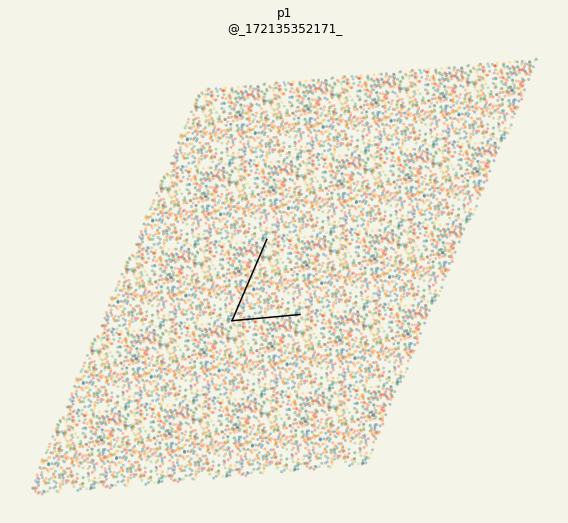

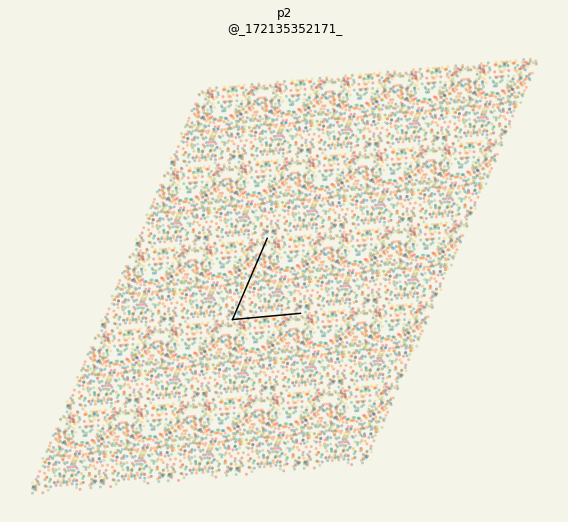

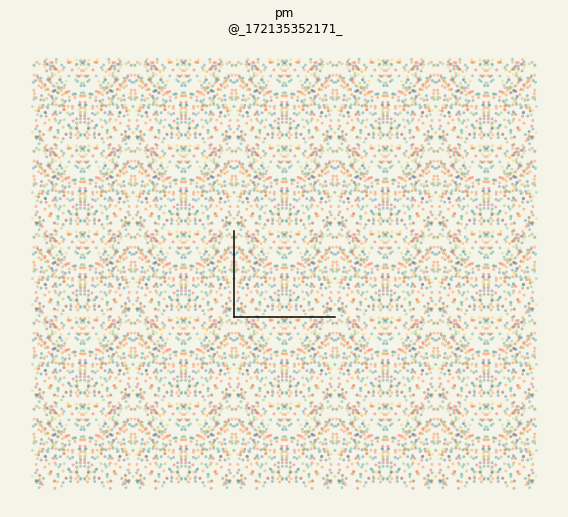

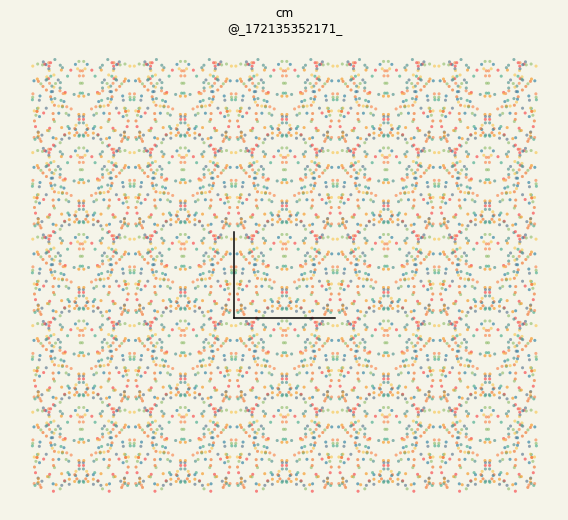

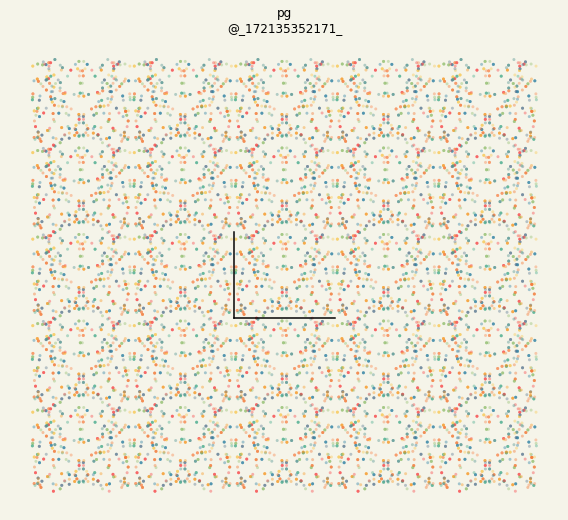

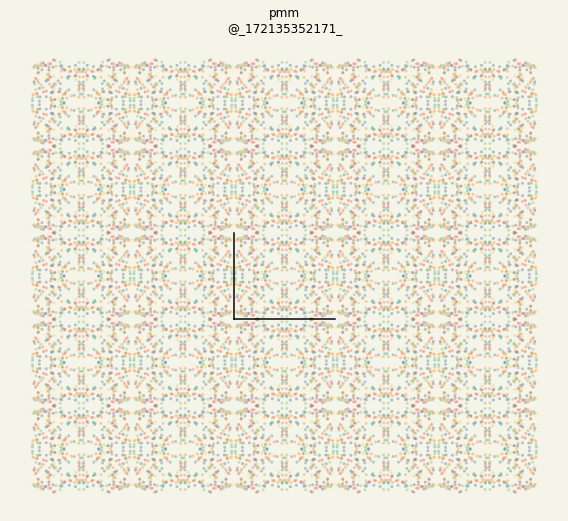

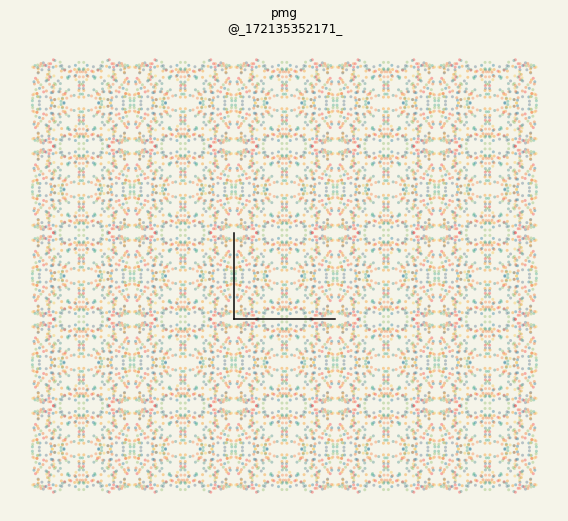

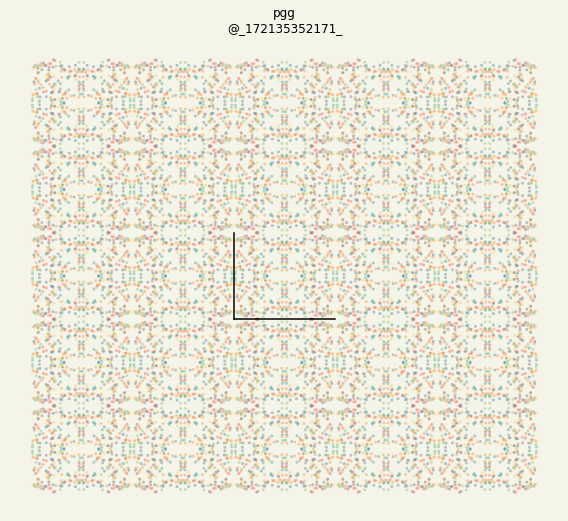

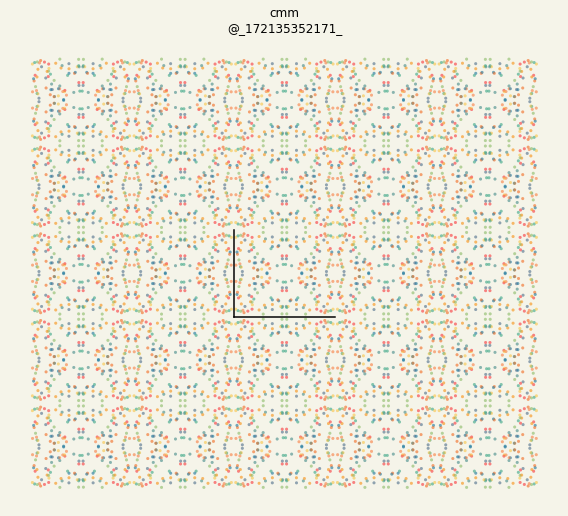

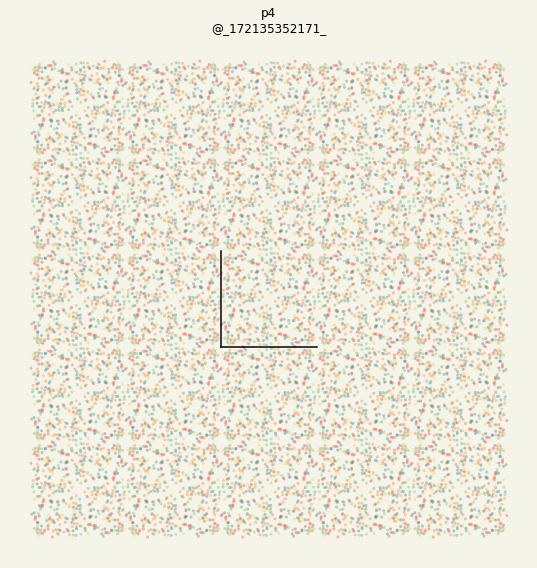

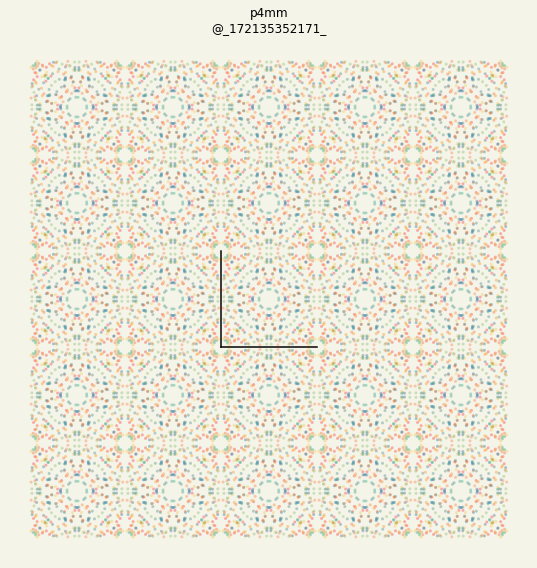

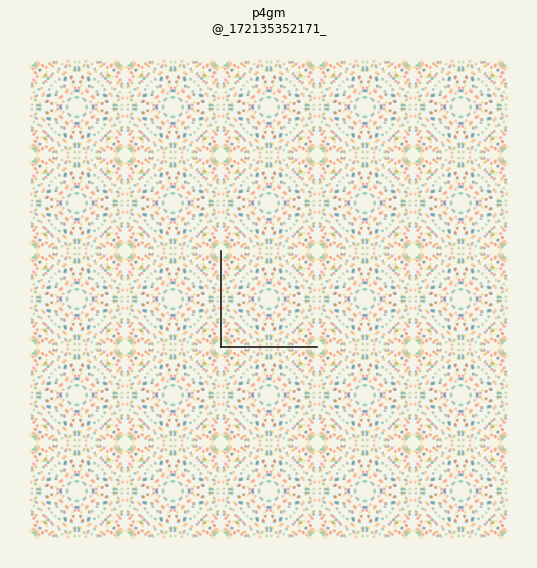

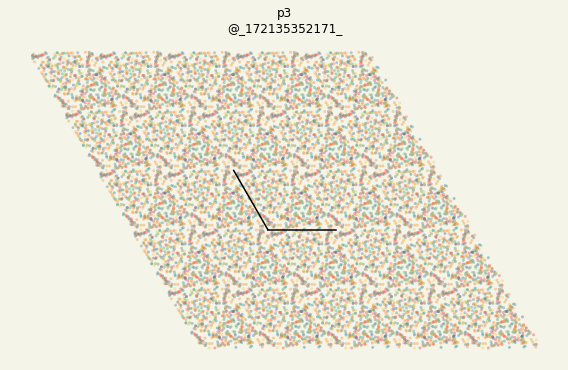

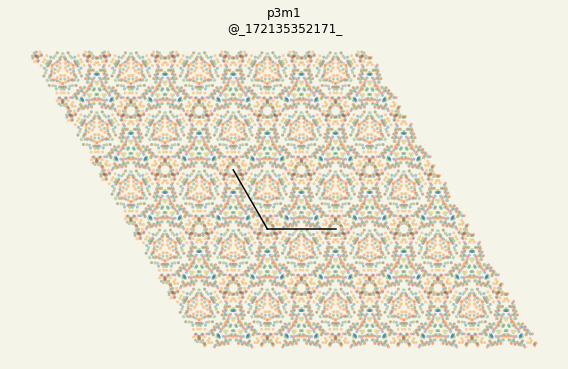

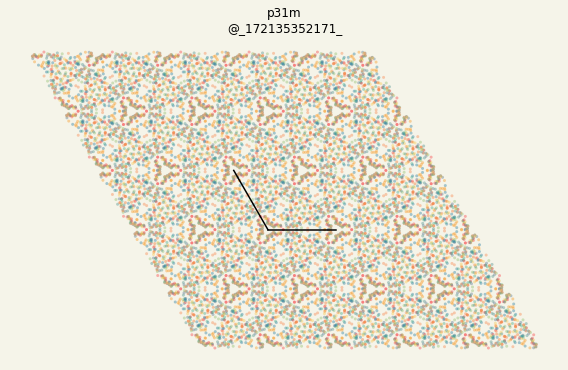

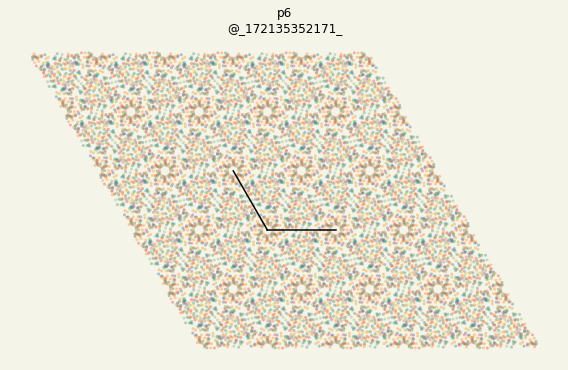

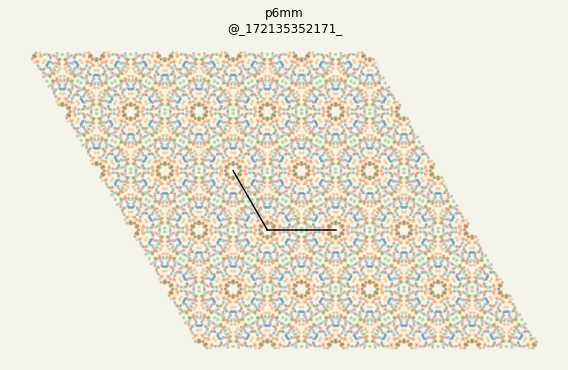

In [4]:
def plot_group(x, basis, g, title, show_basis=False):    
    basis = (g[0] @ basis.flatten()).reshape(basis.shape)    
    if show_basis:
        plt.plot([0, basis[0,0]], [0,basis[1,0]], '-', color='black')
        plt.plot([0, basis[0,1]], [0,basis[1,1]], '-', color='black')
    n = [0, -1, 1, -2, 2]
    # reduce x size to match group
    npoints = x.shape[0] // len(g[1])
    x = x[:npoints, :]    
    points = []
    base_colors = ["f94144","f3722c","f8961e","f9844a","f9c74f","90be6d","43aa8b","4d908e","577590","277da1"]
    colors = ['#' + base_colors[i % len(base_colors)] for i in range(x.shape[0])]
    #colors = [f'black' for i in range(x.shape[0])]
    for i, ns in enumerate(itertools.product(n, repeat=2)):        
        for w in g[1]:
            xw = np.mod((w @ x.T).T, 1)
            xc = (xw[:,:2] + ns) @ basis.T 
            plt.scatter(xc[:,0], xc[:,1], c=colors, marker='.', alpha=0.4,  edgecolors='none' )
            points.append(xc[:,:2])
    x = np.vstack(points)
    #sns.kdeplot(x=x[:,0], y=x[:,1], shade=True, bw_adjust=0.2, cmap='Reds')
    if title:
        plt.title(title)
    plt.gca().set_aspect('equal')
    plt.axis('off')
    plt.gca().set_facecolor('#f5f4e9')
    plt.gcf().patch.set_facecolor('#f5f4e9')

def generate_points(x, basis, g):
    basis = (g[0] @ basis.flatten()).reshape(basis.shape)    
    n = [0, -1, 1, -2, 2]
    # reduce x size to match group
    npoints = x.shape[0] // len(g[1])
    x = x[:npoints, :]   
    points = []
    for i, ns in enumerate(itertools.product(n, repeat=2)):        
        for w in g[1]:
            xw = np.mod((w @ x.T).T, 1)
            xc = (xw[:,:2] + ns) @ basis
            points.append(xc[:,:2])
    x = np.vstack(points)
    return x
np.random.seed(0)
npoints = 24 * 20
x = np.hstack((np.random.uniform(size=(npoints,2)) - 0.5, np.ones((npoints,1))))
basis = np.array([[1,0], [0,1]]) + np.random.uniform(size=(2,2))
for k,v in wallpaper.items():
    plt.figure(figsize=(8,8))
    plot_group(x, basis, v, title=f'{k}\n@_172135352171_', show_basis=True)
    plt.tight_layout()
    plt.savefig(k + '.png', dpi=90)

In [5]:
def write_group(f, name, group):
    # tiling code needs to be updated for more than 2D
    def fmt(n):
        return list(np.round(n.astype(float).flatten(), 8))
    projector, members, asymm = group
    result = {'name': name, 'size': len(members), 'members': [], 'projector': fmt(projector)}
    has_identity = False
    for m in members:
        i = np.linalg.inv(m)
        result['members'].append({'g': fmt(m), 'i': fmt(i)})
    json.dump(result, f, indent=True)
    print('Wrote group with', len(members), 'members.')

In [6]:
for k,v in wallpaper.items():
    with open(f'{k}.json', 'w') as f:
        write_group(f, k, v)


Wrote group with 1 members.
Wrote group with 2 members.
Wrote group with 2 members.
Wrote group with 4 members.
Wrote group with 4 members.
Wrote group with 4 members.
Wrote group with 4 members.
Wrote group with 4 members.
Wrote group with 8 members.
Wrote group with 4 members.
Wrote group with 8 members.
Wrote group with 8 members.
Wrote group with 3 members.
Wrote group with 6 members.
Wrote group with 6 members.
Wrote group with 6 members.
Wrote group with 12 members.


In [7]:
N = 64 * 20
for k,v in wallpaper.items():
    Ni = N
    with open(f'{k}.xyz', 'w') as f:
        while Ni > 0:
            x = np.random.uniform()
            y = np.random.uniform()
            if v[2](x,y):
                f.write(f'{x} {y}\n')
                Ni -= 1

In [8]:
# make a movie

from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

data = []
titles = []
for k,v in wallpaper.items():
    data.append(generate_points(x, basis, v))
    titles.append(k)
    
# make it loop
data.append(data[0])
titles.append(titles[0])
def CubicEaseInOut(p):
    if (p < 0.5):
        return 4 * p * p * p
    else:
        f = ((2 * p) - 2)
        return 0.5 * f * f * f + 1

scale = 2
duration = (len(data) - 1) * scale
dpi = 90
fig, ax = plt.subplots(figsize=(800 / dpi, 800 / dpi), dpi=dpi)
points = ax.plot(data[0][:,0], data[1][:,1], color='#333333', marker='.', markeredgewidth=0.0, linestyle='None', alpha=0.2)[0]
ax.set_facecolor('#f5f4e9')
fig.patch.set_facecolor('#f5f4e9')
title = ax.set_title('', fontsize=32, color='#333333',fontname='monospace')
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
ax.axis('off')
#ax.set_xlim(-3,3)
#ax.set_ylim(-3,3)
#plt.tight_layout()
def make_frame(t):
    t /= scale
    s = t % 1
    if s < 0.25:
        s = CubicEaseInOut(s * 4)
    else:
        s = 1
    i = int(t) + 1
    p = data[i] * s + (1 - s) * data[i - 1]
    title.set_text(titles[i])
    points.set_data(p[:,0], p[:,1])
    ax.set_facecolor('#f5f4e9')
    return mplfig_to_npimage(fig)

animation = VideoClip(make_frame, duration=duration)
animation.write_gif('matplotlib.gif', fps=15)



AttributeError: 'float' object has no attribute 'shape'

## 3D

In [9]:
import requests
from bs4 import BeautifulSoup as BS

In [46]:
projectors3d = {             
    'Hexagonal':
    np.array([
        3 * [1] + 6 * [0], #ax
        3 * [-1/2] + 6 * [0], #bx
        9 * [0], #cx
        9 * [0], #ay
        3 * [0] + 3 * [np.sqrt(3)/2] + 3 * [0], #by
        9 * [0], #cy
        9 * [0], #az
        9 * [0], #bz,
        6 * [0] + 3 * [1], #cz        
    ]),
    'Triclinic':np.eye(9),
}

In [47]:
def get_html(group_no):
    url = f'https://it.iucr.org/Ac/ch2o3v0001/sgtable2o3o{group_no:03}/'
    result = requests.get(url)
    return result.content

In [48]:
def parse_group(html):
    b = BS(html)
    gen_table = b.select_one('div > table.genpos')
    intable = False
    sites = []
    for t in gen_table.find_all('table'):
        for row in t.find_all('tr'):
            data = row.find_all('td')
            if intable:
                for d in data:                
                    if len(d.text.split(')')) == 1:
                        intable = False
                        break
                    text =  ''.join(d.text.split(')')[-1].split())
                    sites.append(text)
                if not intable:
                    print('done', multi, letter, sym)
                    print(sites)
            else:
                try:
                    multi = int(data[0].text)
                    letter = data[1].text
                    sym = data[2].text
                    sites = []
                    intable = True
                except:
                    pass
    asymm = b.select('td.asymmetricunit')[1].text
    asymm = ''.join(asymm.split())
    p = b.select_one('tr.sgheader').select('td.sgheader')[-1].text.strip()
    print(sites)
    return projectors3d[p], [str2mat(t) for t in sites], asymm_constraints(asymm)

In [49]:
def get_group(number):
    return parse_group(get_html(number))

In [50]:
g = 176
group = get_group(g)
with open(f'{g}.json', 'w') as f:
    write_group(f, f'{g}', group)
N = 64 * 20
Ni = N
with open(f'{g}.xyz', 'w') as f:
    while Ni > 0:
        x = np.random.uniform()
        y = np.random.uniform()
        z = np.random.uniform()
        if group[2](x,y,z):
            f.write(f'{x} {y} {z}\n')
            Ni -= 1

['x,y,z', '-y,x-y,z', '-x+y,-x,z', '-x,-y,z+1/2', 'y,-x+y,z+1/2', 'x-y,x,z+1/2', '-x,-y,-z', 'y,-x+y,-z', 'x-y,x,-z', 'x,y,-z+1/2', '-y,x-y,-z+1/2', '-x+y,-x,-z+1/2']
Wrote group with 12 members.


In [40]:
box_ub = np.eye(3).flatten() * 50
print(box_ub.reshape(3,3))
box_b = np.zeros(9)
for i in range(9):
    for j in range(9):
        box_b[i] += box_ub[j] * group[0].flatten()[i * 9 + j] 
box_b = box_b.reshape(3,3)
box_ub = np.linalg.inv(box_b.reshape(3,3))
print(box_b)
print(box_ub)

[[50.  0.  0.]
 [ 0. 50.  0.]
 [ 0.  0. 50.]]
[[ 50.         -25.           0.        ]
 [ 43.30127019   0.           0.        ]
 [  0.           0.          50.        ]]
[[ 0.          0.02309401  0.        ]
 [-0.04        0.04618802  0.        ]
 [ 0.          0.          0.02      ]]


In [41]:
p = np.array([x,y,z])

In [45]:
print((p @ box_b) @ box_ub, p)

[0.09254417 0.51706408 0.04030191] [0.09254417 0.51706408 0.04030191]
